# For a Better Criminal Justice System: Analyzing Recidivism and Prison Populations in the US

#### Data sourced from:
- [Sentencing Project, State Imprisonment Rate](https://www.sentencingproject.org/the-facts/#rankings)
    - "Research on incarceration has traditionally centered on state-level data: specifically state prison populations or the statewide combined prison and jail population. Using the state as the unit of analysis is sufficient for understanding the broad contours of incarceration in the United States, but it does not provide the level of detail necessary to unpack its causes and consequences."
    
-[Bureau of Justice Statistics, National Prisoners Statistics Program](https://www.kaggle.com/christophercorrea/prisoners-and-crime-in-united-states?select=crime_and_incarceration_by_state.csv)

    - "The Bureau of Justice Statistics administers the National Prisoners Statistics Program (NPS), an annual data collection effort that began in response to a 1926 congressional mandate. The population statistics reflect each state's prisoner population as of December 31 for the recorded year. Prisoners listed under federal jurisdiction are incarcerated by the U.S. Bureau of Prisons."
    
- [Iowa Department of Corrections](https://data.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4), [Kaggle, slonnadube](https://www.kaggle.com/slonnadube/recidivism-for-offenders-released-from-prison)
    - "This dataset reports whether an offender is re-admitted to prison or not within three years from being released from prison in Iowa. The recidivism reporting year is the fiscal year (year ending June 30) marking the end of the three year tracking period.
       The Department of Corrections uses recidivism as an indicator on whether strategies are reducing offenders relapse into criminal behavior. A three year time frame is used as studies have shown if an offender relapses into criminal behavior it is most likely to happen within three years of being released."
       
- [Prison Policy Initiative](https://www.prisonpolicy.org/profiles/)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib.patches import Patch
from matplotlib import pyplot
plt.style.use('ggplot')
from imblearn.over_sampling import SMOTE

import pandas as pd
from pandas import Grouper
from pandas.plotting import lag_plot

from pandas import datetime


import seaborn as sns

## Time series libraries
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper

import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.stattools import adfuller
import altair as alt


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Classification libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor  
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler


import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance

## Auto EDA
from ClfAutoEDA import *

from numpy import log


import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import warnings

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from ipykernel import kernelapp as app
[2021-06-24 11:06:16,609] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[fbprophet] or u8darts[all].
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed i

### 1. Prep for Modeling
### 2. Preliminary Model Analysis 
### 3A. Model Tuning with SMOTE
### 3B. Model Tuning with Feature Selection, Hyperparameter Tuning via Gridsearch and SMOTE
### 4. Model Overview and Conclusion


## 1. Prep for Modeling

In [2]:
data = pd.read_csv('data_for_modeling.csv')
data.head()

,Fiscal Year Released,Recidivism Reporting Year,Ethnicity,Sex,Age At Release,Convicting Offense Classification,Convicting Offense Type,Convicting Offense Subtype,Release Type,Part of Target Population,Recidivism
0,2010,2013,White - Non-Hispanic,Male,Under 25,D Felony,Violent,Assault,Parole,Yes,1
1,2010,2013,White - Non-Hispanic,Male,55 and Older,D Felony,Public Order,OWI,Parole,Yes,1
2,2010,2013,White - Non-Hispanic,Male,25-34,D Felony,Property,Burglary,Parole,Yes,1
3,2010,2013,White - Non-Hispanic,Male,55 and Older,C Felony,Drug,Trafficking,Parole,Yes,1
4,2010,2013,Black - Non-Hispanic,Male,25-34,D Felony,Drug,Trafficking,Parole,Yes,1


In [3]:
mm = MinMaxScaler()

data[['Fiscal Year Released', 'Recidivism Reporting Year']] = mm.fit_transform(data[['Fiscal Year Released', 
                                                               'Recidivism Reporting Year']])

#### Creating dummydf

In [4]:
dummydata = pd.get_dummies(data)
dummydata.head()

,Fiscal Year Released,Recidivism Reporting Year,Recidivism,Ethnicity_American Indian or Alaska Native - Hispanic,Ethnicity_American Indian or Alaska Native - Non-Hispanic,Ethnicity_Asian or Pacific Islander - Hispanic,Ethnicity_Asian or Pacific Islander - Non-Hispanic,Ethnicity_Black - Hispanic,Ethnicity_Black - Non-Hispanic,Ethnicity_White - Hispanic,...,Convicting Offense Subtype_Traffic,Convicting Offense Subtype_Trafficking,Convicting Offense Subtype_Vandalism,Convicting Offense Subtype_Weapons,Release Type_Discharged End of Sentence,Release Type_Parole,Release Type_Paroled to Detainer,Release Type_Special Sentence,Part of Target Population_No,Part of Target Population_Yes
0,0.0,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.0,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0.0,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.0,0.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0.0,0.0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


#### Creating target and feature variables

In [5]:
y = dummydata['Recidivism']
X = dummydata.drop('Recidivism', axis=1)

#### Train/test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19365, 68) (19365,)
(4842, 68) (4842,)


In [7]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    12711
1     6654
Name: Recidivism, dtype: int64


0    3167
1    1675
Name: Recidivism, dtype: int64


In [8]:
print('Train Group Shape: ', X_train.shape)
print('Test Group Shape: ', X_test.shape)

Train Group Shape:  (19365, 68)
Test Group Shape:  (4842, 68)


## 2. Preliminary Model Analysis

#### Creating list and for loop to analyze models

In [9]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.659592 (0.002957)
KNN: 0.623909 (0.008770)
CART: 0.622309 (0.009140)
RFC: 0.630056 (0.009751)
SVM: 0.656287 (0.001701)
NB: 0.364317 (0.005191)


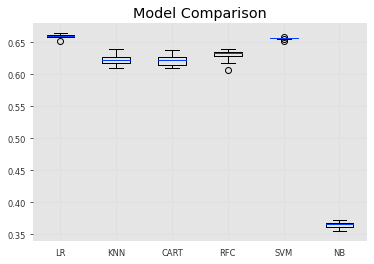

In [10]:
pyplot.boxplot(results, labels=names)
pyplot.title('Model Comparison')
pyplot.show()

#### Based on our preliminary model analysis, we'll narrow our approach to: 
    - Logistic Regression
    - Decision Tree Classification
    - Random Forest Classification
    - Support Vector Machine

### Vanilla Logistic Regression 

In [11]:
# Create instance of model
lreg = LogisticRegression()

# Pass training data into model
lreg.fit(X_train, y_train)

LogisticRegression()

In [12]:
# Predict
y_pred_lreg = lreg.predict(X_test)

##### Checking metrics/scores

In [13]:
# Confusion Matrix
print('Logistic Regression')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg))

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg) * 100,2)
print('Accuracy', logreg_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(lreg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(lreg.score(X_test, y_test)))

Logistic Regression


Confusion Matrix
[[3027  140]
 [1522  153]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.96      0.78      3167
           1       0.52      0.09      0.16      1675

    accuracy                           0.66      4842
   macro avg       0.59      0.52      0.47      4842
weighted avg       0.62      0.66      0.57      4842

--------------------------------------------------------------------------------
Accuracy 65.68 %
Accuracy on training set: 0.662
Accuracy on test set: 0.657


Confusion matrix
[[3027  140]
 [1522  153]]


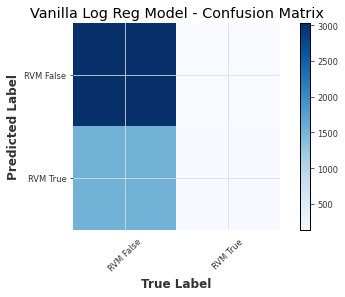

In [14]:
def plot_confusion_matrix(lreg, names, title="Vanilla Log Reg Model - Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    
cm = confusion_matrix(y_test, y_pred_lreg)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["RVM False","RVM True"])

#### Our data is highly imbalanced. Let's try other modeling methods before oversampling. 

### Vanilla Decision Tree Classifier

In [15]:
# Create model object
dtree = DecisionTreeClassifier()

# Fit to training sets
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [16]:
# Predict
y_pred_dtree = dtree.predict(X_test)

##### Checking metrics/scores

In [17]:
# Score It
print('Decision Tree')
# Confusion Matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_dtree))

# Classification Report
print('--'*40)
print('Classification Report','\n',classification_report(y_test, y_pred_dtree))

# Accuracy
print('--'*40)
dtree_accuracy = round(accuracy_score(y_test, y_pred_dtree)*100,2)
print('Accuracy',dtree_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(dtree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dtree.score(X_test, y_test)))

Decision Tree


Confusion Matrix
[[2572  595]
 [1155  520]]
--------------------------------------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           0       0.69      0.81      0.75      3167
           1       0.47      0.31      0.37      1675

    accuracy                           0.64      4842
   macro avg       0.58      0.56      0.56      4842
weighted avg       0.61      0.64      0.62      4842

--------------------------------------------------------------------------------
Accuracy 63.86 %
Accuracy on training set: 0.774
Accuracy on test set: 0.639


Confusion matrix
[[2572  595]
 [1155  520]]


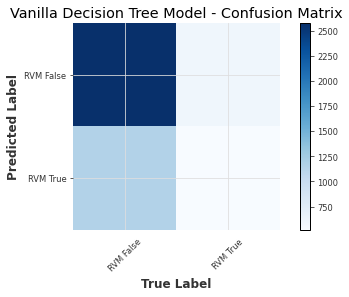

In [18]:
def plot_confusion_matrix(dtree, names, title="Vanilla Decision Tree Model - Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    
cm = confusion_matrix(y_test, y_pred_dtree)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["RVM False","RVM True"])

### Vanilla Random Forest Classifier

In [19]:
# Create model object
rfc = RandomForestClassifier(n_estimators = 200)

# Fit model to training data
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [20]:
# Predict
y_pred_rfc = rfc.predict(X_test)

##### Checking metrics/scores

In [21]:
# Score It
print('Random Forest')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rfc))

# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_rfc))

# Accuracy
print('--'*40)
rf_accuracy = round(accuracy_score(y_test, y_pred_rfc)*100,2)
print('Accuracy', rf_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))

Random Forest


Confusion Matrix
[[2572  595]
 [1144  531]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      3167
           1       0.47      0.32      0.38      1675

    accuracy                           0.64      4842
   macro avg       0.58      0.56      0.56      4842
weighted avg       0.62      0.64      0.62      4842

--------------------------------------------------------------------------------
Accuracy 64.09 %
Accuracy on training set: 0.774
Accuracy on test set: 0.641


### Vanilla Support Vector Machine Classifier

In [22]:
# Create model object
svc = SVC(kernel='linear', gamma='auto')

# Fit model to training data
svc.fit(X_train,y_train)

SVC(gamma='auto', kernel='linear')

In [23]:
# Predict
y_pred_svc = svc.predict(X_test)

##### Checking metrics/scores

In [24]:
# Score It
print('SVC')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_svc))

# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_svc))

# Accuracy
print('--'*40)
rf_accuracy = round(accuracy_score(y_test, y_pred_svc)*100,2)
print('Accuracy', rf_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test, y_test)))

SVC


Confusion Matrix
[[3086   81]
 [1598   77]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      3167
           1       0.49      0.05      0.08      1675

    accuracy                           0.65      4842
   macro avg       0.57      0.51      0.44      4842
weighted avg       0.60      0.65      0.54      4842

--------------------------------------------------------------------------------
Accuracy 65.32 %
Accuracy on training set: 0.658
Accuracy on test set: 0.653


### Preliminary Model Analysis Summary

In [25]:
print('*Log Reg Scores*', '\n', classification_report(y_test, y_pred_lreg))
print('------------------------------------------------------------------------')
print('*Decision Tree Scores*', '\n', classification_report(y_test, y_pred_dtree))
print('------------------------------------------------------------------------')
print('*RFC Scores*', '\n', classification_report(y_test, y_pred_rfc))
print('------------------------------------------------------------------------')
print('*SVM Scores*', '\n', classification_report(y_test, y_pred_svc))

*Log Reg Scores* 
               precision    recall  f1-score   support

           0       0.67      0.96      0.78      3167
           1       0.52      0.09      0.16      1675

    accuracy                           0.66      4842
   macro avg       0.59      0.52      0.47      4842
weighted avg       0.62      0.66      0.57      4842

------------------------------------------------------------------------
*Decision Tree Scores* 
               precision    recall  f1-score   support

           0       0.69      0.81      0.75      3167
           1       0.47      0.31      0.37      1675

    accuracy                           0.64      4842
   macro avg       0.58      0.56      0.56      4842
weighted avg       0.61      0.64      0.62      4842

------------------------------------------------------------------------
*RFC Scores* 
               precision    recall  f1-score   support

           0       0.69      0.81      0.75      3167
           1       0.47      0.3

#### Preliminary Model Analysis Summary

##### Regardless of model, our data is highly imbalanced. Before we finalize our model selection, we need to: 
    - Introduce SMOTE to fix our sampling issues. 
    - Inspect feature importance. 
    - Monitor overfitting. 

## 3A. Model Tuning with SMOTE

#### Introducing SMOTE to oversample the minority class. 

In [26]:

print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train1, y_train1 = smote.fit_sample(X_train, y_train) 
#X1, y1 = smote.fit_resample(X, y)

print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train).value_counts()) 

Original class distribution: 

0    15878
1     8329
Name: Recidivism, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

0    12711
1     6654
Name: Recidivism, dtype: int64


### Logistic Regression with SMOTE

In [27]:
# Create instance of model
lreg1 = LogisticRegression()

# Pass training data into model
lreg1.fit(X_train1, y_train1)

LogisticRegression()

In [28]:
# Predict
y_pred_lreg1 = lreg1.predict(X_test)

##### Checking scores

In [29]:
lreg1_score = np.mean(cross_val_score(lreg1, X, y, cv=kfold, scoring='roc_auc'))

# Confusion Matrix
print('Logistic Regression with SMOTE')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_lreg1))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test,y_pred_lreg1))

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, y_pred_lreg1) * 100,2)
print('Accuracy', logreg_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(lreg1.score(X_train1, y_train1)))
print("Accuracy on test set: {:.3f}".format(lreg1.score(X_test, y_test)))
print('\n')
print("=== All AUC Scores ===")
print(lreg1_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - LogReg with SMOTE and Gridsearch: ", lreg1_score.mean())

Logistic Regression with SMOTE


Confusion Matrix
[[2035 1132]
 [ 761  914]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      3167
           1       0.45      0.55      0.49      1675

    accuracy                           0.61      4842
   macro avg       0.59      0.59      0.59      4842
weighted avg       0.63      0.61      0.62      4842

--------------------------------------------------------------------------------
Accuracy 60.9 %
Accuracy on training set: 0.643
Accuracy on test set: 0.609


=== All AUC Scores ===
0.6357707268836535


=== Mean AUC Score ===
Mean AUC Score - LogReg with SMOTE and Gridsearch:  0.6357707268836535


### Random Forest Classifier with SMOTE

In [30]:
# Create model object
rfc1 = RandomForestClassifier(n_estimators = 100, random_state=42)

# Fit model to training data
rfc1.fit(X_train1,y_train1)

RandomForestClassifier(random_state=42)

In [31]:
# Predict
y_pred_rfc1 = rfc1.predict(X_test)

##### Checking scores

In [32]:
rfc1_score = np.mean(cross_val_score(rfc1, X, y, cv=kfold, scoring='roc_auc'))

# Score It
print('Random Forest with SMOTE')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_rfc1))

# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_rfc1))

# Accuracy
print('--'*40)
rf_accuracy = round(accuracy_score(y_test, y_pred_rfc1)*100,2)
print('Accuracy', rf_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(rfc1.score(X_train1, y_train1)))
print("Accuracy on test set: {:.3f}".format(rfc1.score(X_test, y_test)))
print('\n')
print("=== All AUC Scores ===")
print(rfc1_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - LogReg with SMOTE and Gridsearch: ", rfc1_score.mean())

Random Forest with SMOTE


Confusion Matrix
[[2141 1026]
 [ 868  807]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      3167
           1       0.44      0.48      0.46      1675

    accuracy                           0.61      4842
   macro avg       0.58      0.58      0.58      4842
weighted avg       0.62      0.61      0.61      4842

--------------------------------------------------------------------------------
Accuracy 60.88 %
Accuracy on training set: 0.794
Accuracy on test set: 0.609


=== All AUC Scores ===
0.6068383923132804


=== Mean AUC Score ===
Mean AUC Score - LogReg with SMOTE and Gridsearch:  0.6068383923132804


##### Model is overfitting. We will check these metrics after gridsearching. 

### Support Vector Machine Classifier with SMOTE

In [33]:
# Create model object
svc1 = SVC(kernel='linear', gamma='auto')

# Fit model to training data
svc1.fit(X_train1,y_train1)

SVC(gamma='auto', kernel='linear')

In [34]:
# Predict
y_pred_svc1 = svc1.predict(X_test)

##### Checking scores

In [35]:
svc1_score = np.mean(cross_val_score(svc1, X, y, cv=kfold, scoring='roc_auc'))

# Score It
print('SVC with SMOTE')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_svc1))

# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, y_pred_svc1))

# Accuracy
print('--'*40)
rf_accuracy = round(accuracy_score(y_test, y_pred_svc1)*100,2)
print('Accuracy', rf_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(svc1.score(X_train1, y_train1)))
print("Accuracy on test set: {:.3f}".format(svc1.score(X_test, y_test)))
print('\n')
print("=== All AUC Scores ===")
print(svc1_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - LogReg with SMOTE and Gridsearch: ", svc1_score.mean())

SVC with SMOTE


Confusion Matrix
[[1811 1356]
 [ 652 1023]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.57      0.64      3167
           1       0.43      0.61      0.50      1675

    accuracy                           0.59      4842
   macro avg       0.58      0.59      0.57      4842
weighted avg       0.63      0.59      0.60      4842

--------------------------------------------------------------------------------
Accuracy 58.53 %
Accuracy on training set: 0.636
Accuracy on test set: 0.585


=== All AUC Scores ===
0.5403669477325722


=== Mean AUC Score ===
Mean AUC Score - LogReg with SMOTE and Gridsearch:  0.5403669477325722


## 3B. Model Tuning with Feature Selection, Hyperparameter Tuning via Gridsearch

### Logistic Regression with SMOTE & Gridsearch

In [36]:
print('Parameters currently in use:\n')
print(lreg.get_params())

Parameters currently in use:

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [37]:
# Create instance of model
lreg2 = LogisticRegression()


##### Creating paramter grid for search

In [38]:
lreg2_grid = {
    'fit_intercept': [True, False],
    'C': [1, 3, 5],
    'class_weight': [None, 'balanced'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 150],
    'random_state': [None, 1, 3]
}

In [39]:
lreg2_grid_search = GridSearchCV(lreg2, lreg2_grid)
lreg2_grid_search.fit(X_train1, y_train1)

print(f"Training Accuracy: {lreg2_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {lreg2_grid_search.best_params_}")

Training Accuracy: 64.00%

Optimal Parameters: {'C': 5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100, 'random_state': None, 'solver': 'liblinear'}


In [40]:
lreg2_grid_search_pred = lreg2_grid_search.predict(X_test)

##### Checking metrics and scores 

In [41]:
lreg2_score = np.mean(cross_val_score(lreg2, X, y, cv=kfold, scoring='roc_auc'))

# Confusion Matrix
print('Logistic Regression with SMOTE and Gridsearch')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, lreg2_grid_search_pred))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test,lreg2_grid_search_pred))

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(y_test, lreg2_grid_search_pred) * 100,2)
print('Accuracy', logreg_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(lreg2_grid_search.score(X_train1, y_train1)))
print("Accuracy on test set: {:.3f}".format(lreg2_grid_search.score(X_test, y_test)))
print('\n')
print("=== All AUC Scores ===")
print(lreg2_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - LogReg with SMOTE and Gridsearch: ", lreg2_score.mean())

Logistic Regression with SMOTE and Gridsearch


Confusion Matrix
[[2062 1105]
 [ 775  900]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      3167
           1       0.45      0.54      0.49      1675

    accuracy                           0.61      4842
   macro avg       0.59      0.59      0.59      4842
weighted avg       0.63      0.61      0.62      4842

--------------------------------------------------------------------------------
Accuracy 61.17 %
Accuracy on training set: 0.645
Accuracy on test set: 0.612


=== All AUC Scores ===
0.6357707268836535


=== Mean AUC Score ===
Mean AUC Score - LogReg with SMOTE and Gridsearch:  0.6357707268836535


### Random Forest Classifier with SMOTE, Feature Selection and Gridsearch

In [42]:
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


##### Creating feature importance function

In [43]:
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

##### Checking feature importance

In [44]:
base_imp = imp_df(X_train1.columns, rfc1.feature_importances_)
base_imp

,feature,feature_importance
0,Fiscal Year Released,0.124439
1,Recidivism Reporting Year,0.124427
2,Ethnicity_White - Non-Hispanic,0.042574
3,Ethnicity_Black - Non-Hispanic,0.040156
4,Age At Release _25-34,0.037028
...,...,...
63,Convicting Offense Subtype_Animals,0.000152
64,Convicting Offense Classification_A Felony,0.000084
65,Convicting Offense Classification_Simple Misde...,0.000044
66,Convicting Offense Classification_Sexual Preda...,0.000032


###### Using feature importance to narrow our search. 

In [45]:
#Transforming our variables for our RFC model. 
rfc1.feature_importances_  
model = SelectFromModel(rfc1, threshold=0.03, prefit=True)
X_new1 = model.transform(X)
X_new1.shape           

(24207, 7)

##### Using our new x values for train/test split

In [46]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new1, y, test_size=0.2, random_state=42)
print(X_train2.shape, y_train.shape)
print(X_test2.shape, y_test.shape)

(19365, 7) (19365,)
(4842, 7) (4842,)


##### Applying SMOTE to new x, Y

In [47]:
X_train2, y_train2 = smote.fit_sample(X_train2, y_train2) 

In [48]:
# Create instance of model
rfc2 = RandomForestClassifier(random_state=42, n_estimators = 100)


##### Creating parameter grid to search 

In [49]:
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

##### Fitting gridsearch RFC

In [50]:
rf_grid_search = GridSearchCV(rfc2, rf_param_grid, verbose=2)
rf_grid_search.fit(X_train2, y_train2)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   1.2s
[CV] class_weight=None, criterion=

[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.3s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] class_weight=None, c

[CV]  class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   1.0s
[CV] class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   1.0s
[CV] class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   1.0s
[CV] class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150, total=   0.9s
[CV] class_weight=None, c

[CV]  class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   1.4s
[CV] class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   1.2s
[CV] class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  class_weight=None, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] class_weight=None, crit

[CV]  class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   1.1s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   1.1s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   1.2s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   0.9s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   1.3s
[CV] cl

[CV]  class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   2.0s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.0s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.0s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.9s
[CV] cl

[CV]  class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   1.7s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   1.5s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   1.6s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   1.7s
[CV] class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=200 
[CV]  class_weight=None, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=200, total=   1.7s
[CV] cl

[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.8s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   1.0

[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.2s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=150, total=   1.1s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.5s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=1, min_samples_split=10, n_estimators=200, tot

[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   1.2s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   1.2s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   1.0s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=3, min_samples_split=10, n_estimators=150, tot

[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   1.2s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=150 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=150, total=   1.5s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   1.8s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   2.5s
[CV] class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced, criterion=gini, min_samples_leaf=5, min_samples_split=5, n_estimators=200, total=   3.4

[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_e

[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150, total=   1.4s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=150, total=   1.3s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_e

[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.9s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=3, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   0.6s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=2

[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.2s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced, criterion=entropy, min_samples_leaf=5, min_samples_spli

[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=150, total=   2.8s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   2.4s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   2.3s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   1.9s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsampl

[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   2.8s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   2.9s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.5s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   2.5s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced_subsampl

[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.4s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.4s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.4s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   1.6s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced_subsampl

[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.5s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.5s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.7s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.7s
[CV] class_weight=balanced_subsample, criterion=gini, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced_

[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   3.4s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   2.4s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   2.3s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=   2.0s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  class_

[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=2, n_estimators=200, total=   2.4s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.2s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.1s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   1.4s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  class_

[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=100, total=   1.2s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   1.6s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150, total=   1.6s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=2, n_estimators=150 
[CV]  class_

[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.9s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.8s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=150, total=   1.7s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   2.7s
[CV] class_weight=balanced_subsample, criterion=entropy, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]

[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed: 19.7min finished


Training Accuracy: 56.43%

Optimal Parameters: {'class_weight': None, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [51]:
# Predict
rfc2_grid_search_pred = rf_grid_search.predict(X_test2)

##### Checking scores

In [52]:
rfc2_score = cross_val_score(rfc2, X_new1, y, cv=kfold, scoring='roc_auc')

# Confusion Matrix
print('RFC Tuned')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test2, rfc2_grid_search_pred))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test2, rfc2_grid_search_pred))

# Accuracy
print('--'*40)
rfc2_accuracy = round(accuracy_score(y_test2, rfc2_grid_search_pred ) * 100,2)
print('Accuracy', logreg_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(rf_grid_search.score(X_train2, y_train2)))
print("Accuracy on test set: {:.3f}".format(rf_grid_search.score(X_test2, y_test2)))
print('\n')
print("=== All AUC Scores ===")
print(rfc2_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest with SMOTE and Gridsearch: ", rfc2_score.mean())

RFC Tuned


Confusion Matrix
[[1854 1313]
 [ 851  824]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.59      0.63      3167
           1       0.39      0.49      0.43      1675

    accuracy                           0.55      4842
   macro avg       0.54      0.54      0.53      4842
weighted avg       0.58      0.55      0.56      4842

--------------------------------------------------------------------------------
Accuracy 61.17 %
Accuracy on training set: 0.569
Accuracy on test set: 0.553


=== All AUC Scores ===
[0.57 0.57 0.56 0.6  0.56 0.58 0.57 0.59 0.55 0.57]


=== Mean AUC Score ===
Mean AUC Score - Random Forest with SMOTE and Gridsearch:  0.5707380685327411


##### Model Analysis: 
- Model overfitting has improved. 
- Recall has improved. 
- 

Confusion matrix
[[1854 1313]
 [ 851  824]]


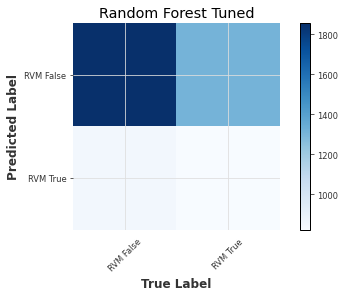

In [53]:
def plot_confusion_matrix(rfc1, names, title="Random Forest Tuned", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Predicted Label')
    plt.xlabel('True Label')
    
cm = confusion_matrix(y_test2, rfc2_grid_search_pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
plot_confusion_matrix(cm, ["RVM False","RVM True"])

### SVC with SMOTE and Gridsearch

In [54]:
print('Parameters currently in use:\n')
print(svc1.get_params())

Parameters currently in use:

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [55]:
svc2 = SVC(kernel='linear', gamma='auto', random_state=42)

##### Creating parameters for gridsearch

In [56]:
svc_param_grid = {'C': [0.1, 1, 10, 25], 
              'gamma': [1, 0.1, 0.01],
             'kernel': ['linear', 'rbf']} 

##### Fitting SVC to gridsearch

In [57]:
svc_search = GridSearchCV(svc2, svc_param_grid, refit=True, verbose=2, cv=3)
svc_search.fit(X_train1, y_train1)

print(f"Training Accuracy: {svc_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {svc_search.best_params_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=0.1, gamma=1, kernel=linear, total=  35.8s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.8s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=  41.2s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=  41.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  49.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  51.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  51.8s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=  33.7s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .................. C=0.1, gamma=0.1, kernel=linear, total=  43.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

[CV] ........................ C=25, gamma=1, kernel=rbf, total= 1.9min
[CV] C=25, gamma=0.1, kernel=linear ..................................
[CV] ................... C=25, gamma=0.1, kernel=linear, total= 1.3min
[CV] C=25, gamma=0.1, kernel=linear ..................................
[CV] ................... C=25, gamma=0.1, kernel=linear, total= 1.1min
[CV] C=25, gamma=0.1, kernel=linear ..................................
[CV] ................... C=25, gamma=0.1, kernel=linear, total= 2.8min
[CV] C=25, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=25, gamma=0.1, kernel=rbf, total=  47.4s
[CV] C=25, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=25, gamma=0.1, kernel=rbf, total=  53.8s
[CV] C=25, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=25, gamma=0.1, kernel=rbf, total= 1.1min
[CV] C=25, gamma=0.01, kernel=linear .................................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 77.0min finished


Training Accuracy: 65.28%

Optimal Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [58]:
# Predict
svc_search_pred = svc_search.predict(X_test)

##### Checking scores

In [59]:
svc2_score = cross_val_score(svc2, X, y, cv=kfold, scoring='roc_auc')

# Confusion Matrix
print('SVC with SMOTE and Gridsearch')
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, svc_search_pred))
print('--'*40)

# Classification Report
print('Classification Report')
print(classification_report(y_test, svc_search_pred))

# Accuracy
print('--'*40)
rfc2_accuracy = round(accuracy_score(y_test, svc_search_pred ) * 100,2)
print('Accuracy', logreg_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(svc_search.score(X_train1, y_train1)))
print("Accuracy on test set: {:.3f}".format(svc_search.score(X_test, y_test)))
print('\n')
print("=== All AUC Scores ===")
print(svc2_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest with SMOTE and Gridsearch: ", svc2_score.mean())

SVC with SMOTE and Gridsearch


Confusion Matrix
[[2059 1108]
 [ 748  927]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      3167
           1       0.46      0.55      0.50      1675

    accuracy                           0.62      4842
   macro avg       0.59      0.60      0.59      4842
weighted avg       0.64      0.62      0.62      4842

--------------------------------------------------------------------------------
Accuracy 61.17 %
Accuracy on training set: 0.695
Accuracy on test set: 0.617


=== All AUC Scores ===
[0.55 0.52 0.56 0.52 0.58 0.58 0.51 0.55 0.5  0.54]


=== Mean AUC Score ===
Mean AUC Score - Random Forest with SMOTE and Gridsearch:  0.5403669477325722


### LinearSVC with SMOTE and Feature Selection

In [60]:
print(X.shape)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new2 = model.transform(X)
X_new2.shape


(24207, 68)


(24207, 28)

##### Creating new train/test split with feature selected X

In [61]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_new2, y, test_size=0.2, random_state=42)
print(X_train2.shape, y_train.shape)
print(X_test2.shape, y_test.shape)

(25422, 7) (19365,)
(4842, 7) (4842,)


##### SMOTE for new X and y train

In [62]:
X_train3, y_train3 = smote.fit_sample(X_train3, y_train3) 

In [63]:
# Create instance of model
lsvc1 = LinearSVC(C=0.01, penalty="l1", dual=False)


In [64]:
lsvc1.fit(X_train3,y_train3)

LinearSVC(C=0.01, dual=False, penalty='l1')

In [65]:
lsvc1_pred = lsvc1.predict(X_test3)

##### Check metrics and scores

In [66]:
lsvc1_score = np.mean(cross_val_score(lsvc1, X_new2, y, cv=kfold, scoring='roc_auc'))

# Score It
print('Random Forest with SMOTE')
# Confusion matrix
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test, lsvc1_pred))

# Classification report
print('--'*40)
print('Classification Report')
print(classification_report(y_test, lsvc1_pred))

# Accuracy
print('--'*40)
rf_accuracy = round(accuracy_score(y_test, lsvc1_pred)*100,2)
print('Accuracy', rf_accuracy,'%')

print("Accuracy on training set: {:.3f}".format(lsvc1.score(X_train3, y_train3)))
print("Accuracy on test set: {:.3f}".format(lsvc1.score(X_test3, y_test3)))
print('\n')
print("=== All AUC Scores ===")
print(lsvc1_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - LogReg with SMOTE and Gridsearch: ", lsvc1_score.mean())

Random Forest with SMOTE


Confusion Matrix
[[1789 1378]
 [ 615 1060]]
--------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.56      0.64      3167
           1       0.43      0.63      0.52      1675

    accuracy                           0.59      4842
   macro avg       0.59      0.60      0.58      4842
weighted avg       0.64      0.59      0.60      4842

--------------------------------------------------------------------------------
Accuracy 58.84 %
Accuracy on training set: 0.605
Accuracy on test set: 0.588


=== All AUC Scores ===
0.6320302711352292


=== Mean AUC Score ===
Mean AUC Score - LogReg with SMOTE and Gridsearch:  0.6320302711352292


## 4. Model Review and Conclusion

### Conclusion
- Despite iteratively test multiple classification models, it's become apparent, across multiple metrics, there is not enough data to classify recidivism with our current data. 
    - While the Bureau of Justice Statistics offers recidivism tools on its website, I was unable to obtain any actionable information while constructing this project. These models will be updated with further data. 
- As we want to identify as many recidivists as possible, broadly, our models were anchored around recall. However, other metrics were considered in model selection and tuning. Specifically, precision and AUC score. 
    - The above summary illustrates our models were never able to surpass 65% in any metric in a reproducible fashion. 

- With our current lack of data, our best performing models were: 
    - SVC with SMOTE
    - LinearSVC with SMOTE, Feature Selection and Gridsarch